In [ ]:
pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Assignment 3 - PyTorch version

This is a version of assignment 3 that is made in [PyTorch](https://pytorch.org/) rather than Tensorflow/Keras.

This is for anyone who has been having trouble running tensorflow on their computer (especially if you have an M2 Mac!), or for students who just generally want the experience of working with a different deep learning library! For several years now PyTorch has become the most [commonly used library by researchers](https://www.assemblyai.com/blog/pytorch-vs-tensorflow-in-2023/) in this field.

PyTorch operates at a lower level of abstraction to Keras. Which means we need to write a bit more code to implement and train our model. This may make the code look more complex at first, but actually this is often preferable as it is hiding less about what the code is doing from you and you have more control over how your models are built, trained and represented.

If you want more practice with PyTorch [take a look at their excellent set of tutorials](https://pytorch.org/tutorials/).

- __Extend the model in this notebook into one which maps (X,Y) -> (R,G,B).__
- __Add at least 2 more layers to the network.__
- __Experiment with alternative activation functions and optimizers.__
- __In a paragraph or so, describe how the image we have created differs from a normal image.__

You can find other images to play with [from SciKit Image here](https://scikit-image.org/docs/dev/api/skimage.data.html), but of course you could experiment with using you're own images. For that you might want to use the [Pillow](https://pillow.readthedocs.io/en/stable/) package which has some [handy functions for loading and manipulating images](https://pillow.readthedocs.io/en/stable/reference/Image.html).

This shouldn't take you longer than an afternoon! __This will be handed in at the end of the module__ so once you have something working it would be _much appreciated_ if you go back over your code and tidy it up, maybe add comments to describe what is happening in the code.

Here are some more lovely examples from [David Ha](https://twitter.com/hardmaru):

![David Ha bw](./images/hardmaru_color.png)

---

If you like this work you could take some ideas explored by David Ha in his blog posts on this topic and re-implement them, or take them further for your final project. I think there is a lot of potential for creating really interesting images and even interesting drawing tools!

In [1]:
import torch
import torch.nn as nn    #networks
import torch.nn.functional as F   # activation function 
import numpy as np
import skimage
import random
from skimage.transform import resize
import matplotlib.pyplot as plt
import torchvision

Set the device for your machine.

For Mac M1/M2 this should say device should be `mps`.

For a machine with an NVIDIA GPU device should be `cuda`.

To run on the CPU of any other machine, device should be `cpu`.

In [2]:
# device = 'cuda'
# device = 'mps' 
device = 'cpu'

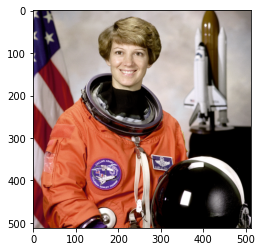

In [3]:
#Get image from skimage
img = skimage.data.astronaut()    # load in colour image
smaller_img = resize(img, (64, 64)) # Resize it just to make things quicker
plt.imshow(img)

In [4]:
# Our function that gets a grid of coordinates    
# this is our input numpy array
def get_mgrid(sidelen):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.'''
    width = np.linspace(-1, 1, sidelen)
    height = np.linspace(-1, 1, sidelen)
    mgrid = np.stack(np.meshgrid(width, height), axis=-1)   #-1 refers to the last dimension 
    #mgrid = np.stack(np.meshgrid)       # stacks the array on top of each other 
    mgrid = np.reshape(mgrid, [-1, 2])     
    return mgrid

Defining the variables we will be using as our training dataset.

In [5]:
image_side_length = smaller_img.shape[0]       # getting only one length 
# Inputs
X = get_mgrid(image_side_length)               
X = np.float32(X) 

#Convert input array to torch tensor
X_torch_tensor = torch.tensor(X, device=device)

# this is our output -> needs to hold three channels, so changing to 3
y = np.reshape(smaller_img, [-1, 3])      
y = np.float32(y)     # this is a numpy array that we need to use to create a pytorch tensor

#convert output array to torch tensor
y_torch_tensor = torch.tensor(y, device=device)

#Get the total number of coordinates 
num_coords = X_torch_tensor.shape[0]

# in pytorch we need to explixtly create tensors to be the input, where tensorflow takes a nnumpy array as an array 
# torch.tensor() -> creates a tensor 
num_coords

4096

In [6]:
# check the shape of the input tensor 
print(X_torch_tensor.shape) 

# check the shape of the output tensor 
print(y_torch_tensor.shape)

torch.Size([4096, 2])
torch.Size([4096, 3])


Lets check to see our data tensor is running on the right device.

For Mac M1/M2 this should say `mps:0`.

For CPU this should say `cpu`.

For a machine with an NVIDIA GPU this should say `cuda`.

In [7]:
print(X_torch_tensor.device)

# the data needs to be on the same device as the model 

cpu


Here we define our model. Our network is a class that inherits from the base model in tensorflow `nn.Module`.

`def __init__(self):` Is where the constructor is defined, this is the function that gets called when our network is first **initialised** here we tell it what the layers are and the parameters that we want to keep track of.

`def forward(self, x):` is where we define the forward pass of the model. This is what we want the model to do with every input data example and define what layers (and activation functions) are ran, and what the output is that our model generates.

In [8]:
# defining our model here  -> we have not yet made a version of it 

class CPPN(nn.Module):     # neural network module is the base class -> CPPN class is gonna inherit from the nn.module 
    def __init__(self):     # def init is the constructor -> passes itself into the function - means 'this class' here meaning CPPN 
      super(CPPN, self).__init__()    # super calls the init function of the nn.module class / the constructor of the base class
      
    # the fully connected layers 

      self.fc1 = nn.Linear(2, 460)      # variables that are owned by the class CPPN  | input is 2 dimensions (x,y coordinate) and output is 16 units 
      self.fc2 = nn.Linear(460, 220)       ##nn.linear is the same as dense in tensorflow -> fully connected layer  | the input is the same as the output of the first layer - therefore 460 here
      self.fc3 = nn.Linear(220, 360)   

      # ADDING NEW LAYERS HERE 

      #self.pool = nn.MaxPool2d(kernel_size=2,padding=1)
      self.fc4 = nn.Linear(360,120)
      self.fc5 = nn.Linear(120,16)
      self.conv6 = nn.Conv2d(16,8,kernel_size=1)      
      self.fc7 = nn.Linear(8,120)     
      self.fc8 = nn.Linear(120,3)        # output layer needs to be 3 dimensions 
      # we are using self. to make it part of the class CPPN - if not it would be deleted 
    
    def forward(self, x):    # function forward gets called when we process the data -> forward pass | x represents our data
        
        # Pass x through first fully connected layer
        x = self.fc1(x) 
        # Relu activation function
        x = F.relu(x)
        
        # Pass through second fully connected layer
        x = self.fc2(x)
        # Relu activation function
        x = F.relu(x)
        
        # Pass through third fully connected layer
        x = self.fc3(x)
        # Sigmoid activation function
        x = F.sigmoid(x)
        
        # ADDING THE NEW LAYERS HERE 

        # Pass through lienar layer
        x = self.fc4(x)
        # Hardtanch activation function
        x = F.hardtanh(x)    
        
        #Pass through fifth fully connected layer
        x = self.fc5(x)
        # Hardswish activation function 
        x = F.hardswish(x)

        x = x.unsqueeze(2).unsqueeze(3)      # add to dimensions to the tensor as convolution layer is expected 4D tensor 
        x = self.conv6(x)                     # Pass through convolutional layer 
        x = F.leaky_relu(x)                 # Leaky_Relu activation function 
        x = x.squeeze(3).squeeze(2)          # remove the extra dimensions 
        
        # Pass through seventh fully connected layer 
        x = self.fc7(x)
        # Leaky_Relu activation function 
        x = F.leaky_relu(x)

        # Pass through eigth fully connected layer
        x = self.fc8(x)
        # Sigmoid activation function 
        x = F.sigmoid(x)

        return x

This is the code where we create our model, we create one version of our network based on our `CPPN` class. We also need to define the loss function we are using `criterion` and what `optimiser` we are using for updating the weights of the network.

In [17]:
num_epochs = 10
batch_size = 1

# instantiating the model/network here
cppn = CPPN()             # object, cppn is an class cppn -> the constructor gets called here
cppn.to(device)           # cppn on the same deveice as the data 
cppn.requires_grad_()     # this network requires gradients because we don't know what the weights are yet 

optimiser = torch.optim.ASGD(cppn.parameters(), lr=0.008)         # we are tellling the optimizer that the variables are the class, CPPN parameters - we want all the weights in the CPPN    - you can have different optimizers (train the model differently) for the same class 
criterion = nn.MSELoss()           # mean squared loss

print(cppn.parameters)

<bound method Module.parameters of CPPN(
  (fc1): Linear(in_features=2, out_features=460, bias=True)
  (fc2): Linear(in_features=460, out_features=220, bias=True)
  (fc3): Linear(in_features=220, out_features=360, bias=True)
  (fc4): Linear(in_features=360, out_features=120, bias=True)
  (fc5): Linear(in_features=120, out_features=16, bias=True)
  (conv6): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
  (fc7): Linear(in_features=8, out_features=120, bias=True)
  (fc8): Linear(in_features=120, out_features=3, bias=True)
)>


This is wheere we train the model. We have a for loop that tells us how many times we want to process data during training. This depends on the size of the data `num_coords`, the number of epochs (cycles through the data) `num_epochs`, and the batch size `batch_size`.

During training we process one batch at a time, our input batch is the `input_batch` variable (which is our batch of coordinates), our output batch is the `true_pixel_values`. 

We use our network model to get approximations of the pixel values `approx_pixel_values` based on the input coordinates, and compare that to our true pixel values using our loss function critera. Once we have our the value of our loss for that batch `loss`, we call `loss.backward()` to backpropagate the error through the network model. We then call `optimiser.step()` to update the weights of our neural network model. 

We do this repeatedly until we have completed the number of cycles through our datset `num_epochs`.

In [10]:
coord_indexes = list(range(0, num_coords))      # random sample of numbers   from 0 to 4096

for i in range( int((num_epochs * num_coords) / batch_size) ):       # go through data = num_epochs * num_coords) / batch_size   - this means that we are not necessarily going through a whole cycle of the data 
    optimiser.zero_grad()       # clean slate
    cppn.zero_grad()            # clean slate

    # Get batch of data
    batch_indexes = torch.tensor(np.array(random.sample(coord_indexes, batch_size)))        # this is our batch at the size of the batch size 
    batch_indexes = batch_indexes.type(torch.long)                                          # convert type to long    long is a bigger int datatype 
    input_batch = X_torch_tensor[batch_indexes]                                             # array of coordinates 
    true_pixel_values = y_torch_tensor[batch_indexes]                                       # corresponding number of pixel values

    # Process data with model
    approx_pixel_values = cppn(input_batch)                                                 # running the network CPPN on a certain batch -> we could call .forward() but we don't have to

    # Calculate loss function
    loss = criterion(true_pixel_values, approx_pixel_values)                                # compare the true values to the approx. values 
    
    # printing loss after a step of each 1000 steps 
    if i % 1000 == 0:          
        print(f'step {i}, loss {loss:.3f}')
    
    #Update model
    loss.backward()       # take the number of loss and backpropegate it through the network -> keeps tracks of what happens to the data as it is being pushed through the network
    optimiser.step()      # using the optimiser we want to make changes to the network based on the loss.backward() 

/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


step 0, loss 0.098
step 1000, loss 0.123
step 2000, loss 0.030
step 3000, loss 0.126
step 4000, loss 0.104
step 5000, loss 0.109
step 6000, loss 0.026
step 7000, loss 0.199
step 8000, loss 0.063
step 9000, loss 0.063
step 10000, loss 0.156
step 11000, loss 0.048
step 12000, loss 0.133
step 13000, loss 0.117
step 14000, loss 0.003
step 15000, loss 0.200
step 16000, loss 0.045
step 17000, loss 0.041
step 18000, loss 0.048
step 19000, loss 0.057
step 20000, loss 0.076
step 21000, loss 0.207
step 22000, loss 0.121
step 23000, loss 0.002
step 24000, loss 0.039
step 25000, loss 0.105
step 26000, loss 0.037
step 27000, loss 0.090
step 28000, loss 0.002
step 29000, loss 0.035
step 30000, loss 0.014
step 31000, loss 0.010
step 32000, loss 0.034
step 33000, loss 0.038
step 34000, loss 0.207
step 35000, loss 0.016
step 36000, loss 0.170
step 37000, loss 0.033
step 38000, loss 0.119
step 39000, loss 0.043
step 40000, loss 0.132


Now lets process the whole image again with the trained model.

In [11]:
with torch.no_grad():
    prediction = cppn(X_torch_tensor)     # tensor is every single pair of coordinates = one single batch -> can be run through the network - we'll do this without keeping track of the gradients 

In [12]:
# calculate the standard deviation of the input image 
std = np.std(img, axis=(0,1))

Now lets visualise the results! 

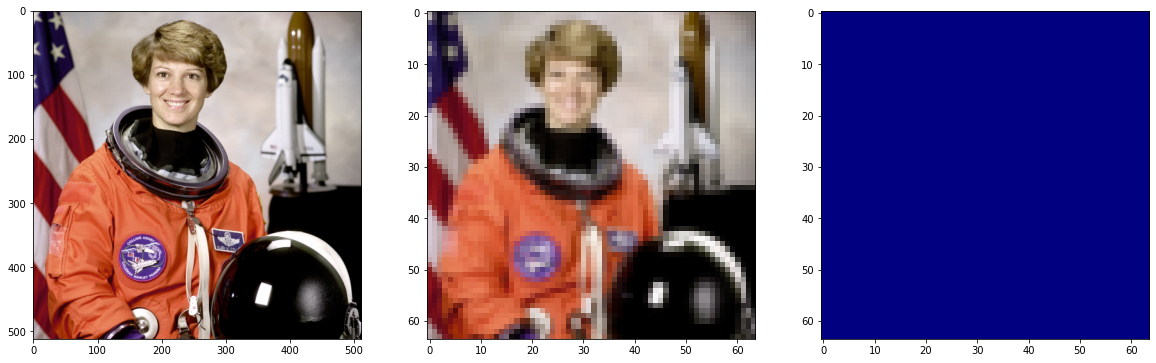

In [16]:
# Reshape the tensor to be 3D instead of 2D 
reconstructed_img = np.reshape(prediction.cpu(), (64,64,3)) 
# Scale the values from [0,1] to [0, 255]
reconstructed_img *= 255
# Convert the tensor into a numpy array, and cast the type into a uint8.
reconstructed_img = reconstructed_img.numpy().astype(np.uint8)

# this needs to be in its own cell, because the reconstructed image will be 'reconstructed' again everytime we run the cell and visualize the output. 
# normalize the images 
# torchvision.transforms.Normalize(reconstructed_img,std)      # this does not work 
# Look at our creation next to the original!
fig, axes_array = plt.subplots(1,3, figsize=(20,10))
axes_array[0].imshow(img, cmap='Blues')
axes_array[1].imshow(smaller_img, cmap='inferno')
axes_array[2].imshow(reconstructed_img)
plt.show()

# OUTPUT IMAGES VERSUS NORMAL IMAGES 

The CPPN network takes RGB values for colour images and x,y pixel coordinates for grayscale images and outputs a colour value. 

CPPNs can generate images of any size, meaning that the resolution can be higher than in a normal image. 

Initially, I was super confused, because I would get the one colour image output (as seen below), but then every time, I ran the displaying function in the cell above, the image would get more and more pixelated and also have added colours to it. ( As seen in the cells below the one colour image) 

But this turned out to makes sense after all: Normal images are usually set in the way that they have a fixed number of pixels, dimensions and resolution, in opposition to CPPN-generated images where the resolution and pixels values can be scaled up and down. This is also the reason we can get different outputs when we run the displaying cell multiple times without retraining the network. The display function can interpret and display the output colour values differently. 


I got this output when I first displayed the output image:

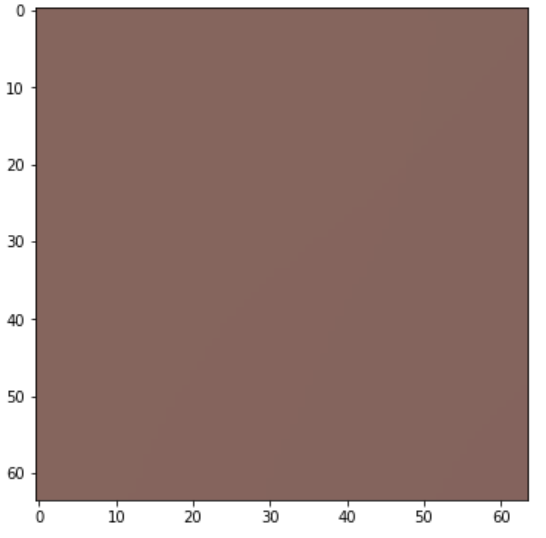

I would either get the total same colour or something with very little difference in the colours - maybe a small gradient in the corner. 
Therefore I added the normalize function before displaying, and then I trained again, but that didn't really seem to have any impact. 

So the one colour output indicates that I the hyperparameters when training are a bit off. 
This is the results with different activation functions and optimizers and epochs and batch sizes, but only after running the displaying cell multiple times

## Output with activation function

Layer: Activation Function 

1: Relu

2: Relu

3: Sigmoid

4: Hardtanh

7: Hardswish 

Epochs: 8

Batch_size: 1

Optimizer: SGD

Output

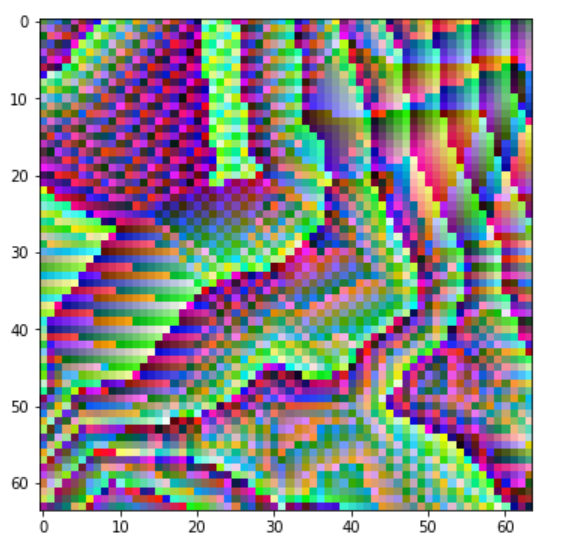

## Output with only sigmoid activation functions 

Epochs: 8

Batch_size: 1

Optimizer: SGD

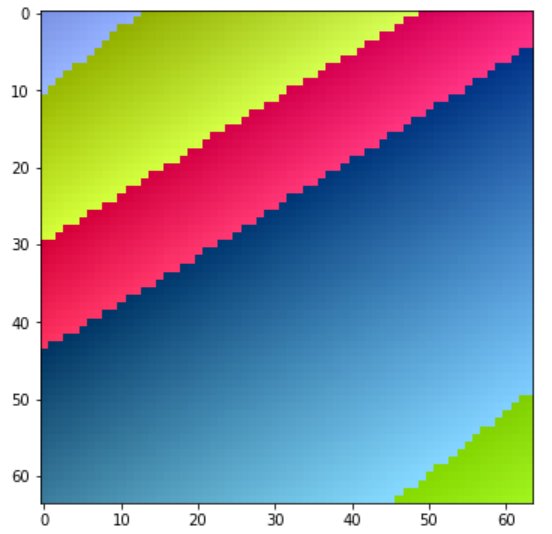

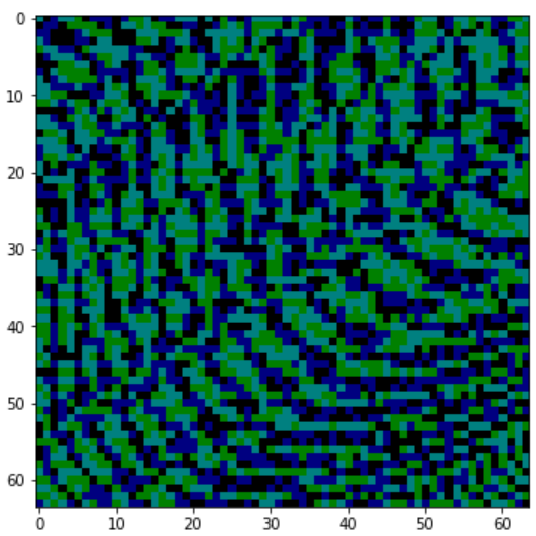

## Output with only hardswish activation function 

Bacth_size: 1

Epochs: 8 

Optimizer: SGD

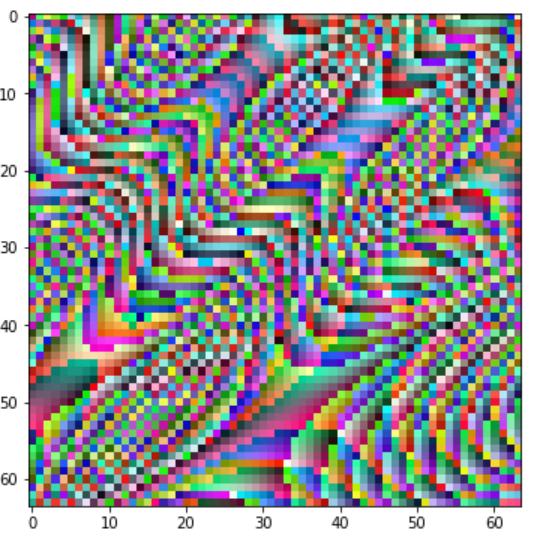



I tried everything. 

Different batch_sizes and different epochs - only with one kind of activation function and a lot of different, and only using sigmoid in the last layer. 
No matter what, I would always get a one colour picture as the first. When I rewrite it I get colours, but then it gets super pixelated. I want an output that is colourful with smooth gradients. 

This was until I tried to upscale the dimensions of each layer, and got slighty better results. 

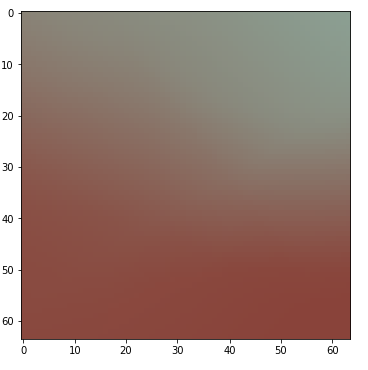

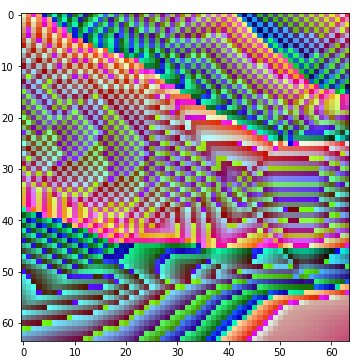


So I tried putting them up even more, and now I am FINALLY getting good results that can show colours without being pixelated. 

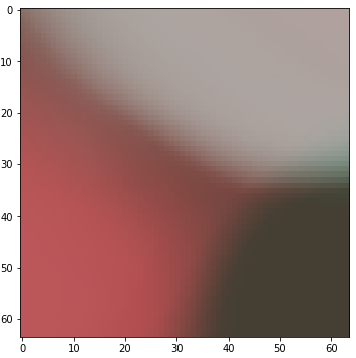

I am gonna try to do the training with different activation functions and optimizers, but with the upscaled dimensions of the layers. 

## Output with: 

Bacth_size: 2 

Epochs: 10

ACtivation functions: 
- relu, leaky_relu, hardtanh, hardswish, leaky_relu, sigmoid 

Optimizer: Adagrad 

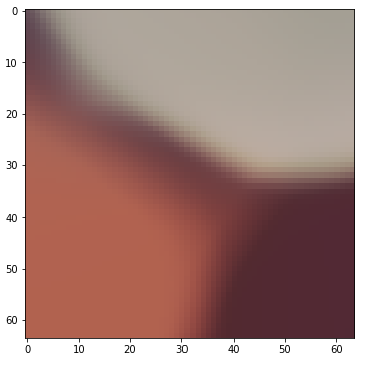

## Output with: 

Bacth_size: 2 

Epochs: 10

ACtivation functions: 
- relu, leaky_relu, hardtanh, hardswish, leaky_relu, sigmoid 

Optimizer: Adam

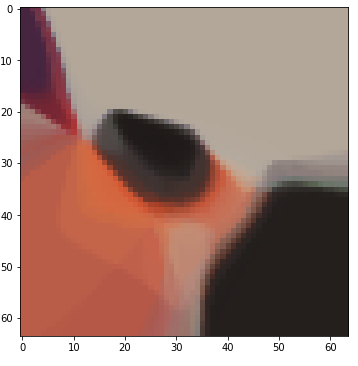

These settings are giving colours very close to the original data, but the Adagrad optimizer seemed to get a less pixelated result. 

And then if I rewrite the display function: 

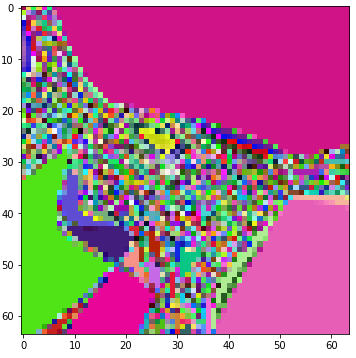

I am trying with the same hyperparameters as above, but with the optimizer, ASGD which implements Implements Averaged Stochastic Gradient Descent, that is made to create a smooth output. 

This surprisingly gives this result. 

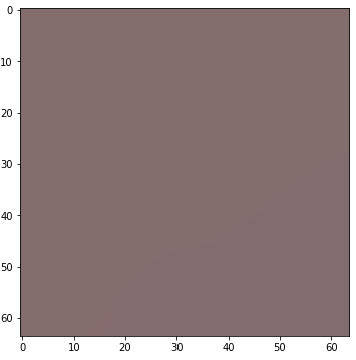

And when rerunning the cell: 

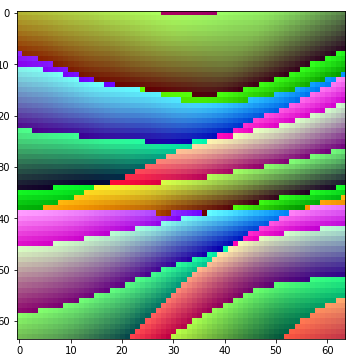

Changed the learning rate for the optimizer to be 1e-0008 instead, added an eigth layer with a leaky_relu activation function and changed the batch_size back to 1. This is the output.
 
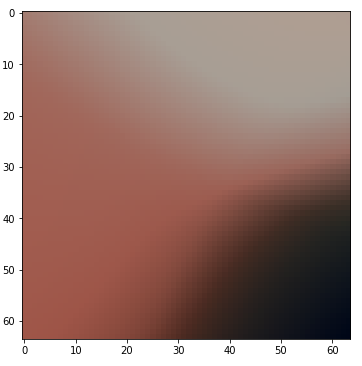